## Test sanssouci on functional MRI data

In this notebook, we test the *sanssouci* module on fMRI data coming from of the *nilearn* package. The data were specifically obtained as described in the *nilearn* python notebook: [Massively univariate analysis of a motor task from the Localizer dataset](https://nilearn.github.io/auto_examples/07_advanced/plot_localizer_mass_univariate_methods.html)



#### Step 1: setup

In [1]:
import numpy as np
import matplotlib.pyplot as plt 

import sanssouci as sa

from nilearn import datasets
from nilearn.input_data import NiftiMasker
from nilearn.image import get_data


#### Step 2: load data

In [2]:
n_samples = 16

localizer_dataset_left = datasets.fetch_localizer_contrasts(
    ["left visual click"], n_subjects=n_samples)

localizer_dataset_right = datasets.fetch_localizer_contrasts(
    ["right visual click"], n_subjects=n_samples)


/Users/lrisser/opt/anaconda3/lib/python3.8/site-packages/numpy/lib/npyio.py:2372: VisibleDeprecationWarning: Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.
  output = genfromtxt(fname, **kwargs)


#### Step 3: quality control

In [3]:
tested_var_left = localizer_dataset_left.ext_vars['pseudo']
# Quality check / Remove subjects with bad tested variate
mask_quality_check_left = np.where(tested_var_left != b'n/a')[0]
n_samples_left = mask_quality_check_left.size
contrast_map_filenames_left = [localizer_dataset_left.cmaps[i]
                          for i in mask_quality_check_left]
tested_var_left = tested_var_left[mask_quality_check_left].astype(float).reshape((-1, 1))

tested_var_right = localizer_dataset_right.ext_vars['pseudo']
# Quality check / Remove subjects with bad tested variate
mask_quality_check_right = np.where(tested_var_right != b'n/a')[0]
n_samples_right = mask_quality_check_right.size
contrast_map_filenames_right = [localizer_dataset_right.cmaps[i]
                          for i in mask_quality_check_right]
tested_var_right = tested_var_right[mask_quality_check_right].astype(float).reshape((-1, 1))


#### Step 4: smoothing

In [5]:
smt = 5

nifti_masker = NiftiMasker(
    smoothing_fwhm=smt,
    memory='nilearn_cache', memory_level=1)  # cache options

fmri_masked_left = nifti_masker.fit_transform(contrast_map_filenames_left)
fmri_masked_left.shape

fmri_masked_right = nifti_masker.fit_transform(contrast_map_filenames_right)
fmri_masked_right.shape

fmri_masked = np.concatenate((fmri_masked_left, fmri_masked_right))
fmri_masked.shape

columns_ok_left=["0"]*fmri_masked_left.shape[0]
columns_ok_right=["1"]*fmri_masked_right.shape[0]
columns_ok=columns_ok_left+columns_ok_right
categ = np.array([float(columns_ok[i]) for i in range(len(columns_ok))])


p = fmri_masked.shape[1]

print('Number of observations:',len(categ))
print('Observation labels:',categ)



Number of observations: 30
Observation labels: [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1.
 1. 1. 1. 1. 1. 1.]


#### Step 5: Permutation p-values

In [6]:
B = 100
pval0=sa.get_perm_p(fmri_masked, categ, B=B , row_test_fun=sa.row_welch_tests)

K=p
piv_stat=sa.get_pivotal_stats(pval0, K=K)


#### Step 6: Calibration

In [7]:
alpha=0.1

lambda_quant=np.quantile(piv_stat, alpha)
thr=sa.t_linear(lambda_quant, np.arange(1,p+1), p)



#### Step 7: Post hoc bound

In [8]:

swt=sa.row_welch_tests(fmri_masked, categ)
p_values=swt['p_value'][:]
p_values=p_values[np.argsort(p_values)]
pvals=p_values[:500]
pvals

bound = sa.max_fp(pvals, thr)
print(bound)


197.0


#### Step 8: Confidence envelopes

In [9]:

max_FP = sa.curve_max_fp(pvals, thr)
print(max_FP)
max_FP=sa.curve_max_fp(p_values, thr)


[  0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   1.   1.   1.   1.
   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   1.   2.   2.
   2.   2.   2.   2.   2.   2.   2.   2.   3.   3.   3.   3.   3.   3.
   3.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   4.   5.   5.
   5.   6.   6.   6.   6.   6.   6.   6.   6.   6.   7.   7.   7.   7.
   7.   7.   7.   7.   8.   8.   8.   8.   9.   9.   9.  10.  10.  10.
  10.  10.  10.  10.  11.  11.  11.  11.  11.  11.  11.  12.  12.  13.
  13.  13.  13.  13.  13.  13.  13.  13.  13.  13.  13.  14.  14.  14.
  14.  14.  14.  14.  15.  15.  15.  15.  15.  16.  16.  16.  16.  16.
  17.  17.  17.  17.  17.  17.  17.  18.  18.  18.  19.  19.  19.  19.
  19.  19.  20.  20.  20.  21.  21.  21.  21.  21.  21.  22.  23.  23.
  24.  24.  24.  24.  25.  25.  25.  25.  25.  25.  26.  26.  26.  27.
  27.  27.  28.  28.  29.  29.  29.  29.  30.  30.  30.  30.  30.  31.
  31.  31.  31.  32.  32.  32.  33.  33.  33.  33.  34.  34.  34.  34.
  34. 

#### Step 9: Show the results

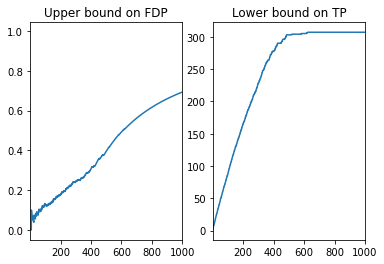

In [10]:

rg = np.arange(1, p+1)
max_FDP = max_FP / rg
min_TP = rg - max_FP
plt.subplot(121)
plt.plot(max_FDP)
plt.title('Upper bound on FDP')
plt.xlim(1, 1000)
plt.subplot(122)
plt.plot(min_TP)
plt.title('Lower bound on TP')
plt.xlim(1, 1000)
plt.show()
